In [1]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import scipy
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.special import gammainc
import os

colors = [c["color"] for c in plt.rcParams["axes.prop_cycle"]]

Notes/questions/to-do
* In the case of $f \sim 10^{-4} - 10^{-2}$, which is more constraining: $\gamma$-ray point source or diffuse constraints? When can each be used?
* Need to make sure the detectable PBHs aren't too close to Earth! **Otherwise they could contribute to the local DM density.**
* **`efficient_angular_sampling`** seems to be failing for low PBH masses

In [2]:
kpc_to_cm = 3.086e21  # 1 kpc in cm
cm_to_kpc = 1 / kpc_to_cm
GeV_to_m_sun = 1 / 1.11543e57
m_sun_to_GeV = 1 / GeV_to_m_sun
GeV_to_erg = 0.001602
erg_to_GeV = 1 / GeV_to_erg
yr_to_s = 365. * 24 * 60**2
s_to_yr = 1 / yr_to_s
L_sun_to_GeV_s = 2.402e36
GeV_s_to_L_sun = 1 / L_sun_to_GeV_s
L_sun_to_erg_s = L_sun_to_GeV_s * GeV_to_erg
erg_s_to_L_sun = 1 / L_sun_to_erg_s

# Best-fit Einasto parameters for Milky Way halo. From PPPC.
alpha_mw = 0.17
r_s_mw = 28.44  # kpc
rho_e_mw = 0.033 * GeV_to_m_sun / cm_to_kpc**3  # M_sun / kpc^3
Omega_cdm = 0.2589  # from Planck 2015
z_eq = 3500.
z_final = 30.  # redshift at which to end PBH halo evolution
d_earth = 8.33  # kpc
age_of_universe = 13e9  # yr
fermi_psf = 0.15 * np.pi / 180.  # arxiv:0902.1089
fermi_psf_solid_angle = 2.*np.pi*(1. - np.cos(fermi_psf))
# Particle physics
alpha_em = 1/137.
m_e = 0.511e-3  # GeV
m_mu = 105.7e-3  # GeV
m_tau = 1.776  # GeV

def load_int_spec_interps(e_low=1, e_high=None):
    """Loads interpolators for integrated photon spectra for different final states,
    using data from PPPC4DMID.
    
    Parameters
    ----------
    e_low, e_high : float
        Energy range over which to compute integrated fluxes. If `e_high` is `None`,
        it will be set to the DM mass.
    
    Returns
    -------
    `dict`s of `interp1d`s for (int de dn/de) and (int de e dn/de) as a function of
    DM mass; a list of final states in the data file.
    """
    # Load data as a structured array
    data = np.genfromtxt("data/dN_dlog10x_gammas.dat", dtype=float, delimiter=' ', names=True)
    fss = data.dtype.names[2:]
    log10x_tab = data["Log10x"]
    m_dm_tab = data["mDM"]
    m_dms = np.array(sorted(list(set(m_dm_tab))))
    if e_high is None:
        e_high = np.max(m_dms)
    int_dnde_interps = {}
    int_e_dnde_interps = {}

    for fs in fss:
        dn_dlog10x_tab = data[fs]
        int_dndes = []
        int_e_dndes = []
        
        for m_dm in m_dms:
            # Select table entries for DM mass
            dm_idxs = np.where(m_dm_tab == m_dm)[0]
            es = m_dm * 10**log10x_tab[dm_idxs]
            dnde = dn_dlog10x_tab[dm_idxs] / (np.log(10) * es)
            # Select energies in [e_low, e_high]
            e_idxs = np.where((e_low <= es) & (es <= e_high))[0]
            es = es[e_idxs]
            dnde = dnde[e_idxs]
            # Compute integrals
            int_dndes.append(scipy.integrate.trapz(dnde, es))
            int_e_dndes.append(scipy.integrate.trapz(es*dnde, es))

        int_dndes = np.array(int_dndes)
        int_e_dndes = np.array(int_e_dndes)
        # Construct interpolators
        int_dnde_interps[fs] = interp1d(m_dms, int_dndes)
        int_e_dnde_interps[fs] = interp1d(m_dms, int_e_dndes)
        
    return int_dnde_interps, int_e_dnde_interps, fss

int_dnde_interps, int_e_dnde_interps, fss = load_int_spec_interps()

def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates.
    
    Notes
    -----
    Assumes Earth is located at (d_earth, 0, 0).
    """
    x = r * np.sin(th) * np.cos(phi)
    y = r * np.sin(th) * np.sin(phi)
    z = r * np.cos(th)
    
    d = np.sqrt((x - d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - np.arccos(z / d)
    l = np.arctan2(y, x - d_earth)
    
    if deg:
        return np.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return np.stack([d, b, l])

def rho_einasto(r, rho_e=rho_e_mw, r_s=r_s_mw, alpha=alpha_mw):
    """Einasto density profile."""
    return rho_e * np.exp(-2/alpha * ((r / r_s)**alpha - 1))

# Total MW DM mass in M_sun. Cross-checked with PPPC.
m_mw_dm = quad(lambda r: 4*np.pi*r**2*rho_einasto(r, rho_e_mw, r_s_mw, alpha_mw),
               0., np.inf, epsabs=0, epsrel=1e-4)[0]

def gamma_tr_sample(x_min, x_max, shape=1, scale=1):
    """Use inverse CDF sampling to sample from a truncated gamma distribution.
    """
    distro = stats.gamma(a=shape, loc=0, scale=scale)
    cdf_min = distro.cdf(x_min)
    cdf_max = distro.cdf(x_max)
    size = np.max([x_min.size, x_max.size])
    
    samples = distro.ppf(cdf_min + np.random.uniform(size=size) * (cdf_max - cdf_min))
#     print(cdf_min, cdf_max, samples)
    
    return samples

In [3]:
class PBHHaloSim(object):
    @classmethod
    def final_states(cl):
        """Returns list of valid DM annihilation final states."""
        return ["e", "c", "b", "t", "W", "Z", "g", "h"]
    
    def __init__(self, mass_dist, f_pbh, m_dm=100, sv=3e-26, fs="b",
                 flux_type="e dnde", b_cut=10, flux_thresh=1.35e-12, n_samples=1000):
        """
        Parameters
        ----------
        mass_dist : float -> np.array or float
            Function to sample from PBH mass distribution. Pass a float to indicate
            a monochromatic mass distribution at the indicated value in M_sun.
        f_pbh : float
            Omega_PBH / Omega_CDM.
        m_dm : float
            Dark matter mass, GeV
        sv : float
            Dark matter thermally-averaged self-annihilation cross section, cm^3/s.
        fs : string
            Annihilation final state.
        flux_type : string
            Use "dnde" to compute fluxes or "e dnde" to compute energy fluxes.
        b_cut : float
            Specifies the latitude cut for calculating the number of detectable PBH
            halos.
        flux_thresh : float
            Flux detectability threshold in cm^-2 s^-1 (for `flux_type` "dnde") or
            erg cm^-2 s^-1 (for `flux_type` "e dnde"). Defaults to the conservative
            threshold for the energy flux above 1 GeV from arXiv:1601.06781.
        n_samples : int
            Number of iterations of the simulation to run.
        """
        if fs not in PBHHaloSim.final_states():
            raise ValueError("Invalid final state")
        self.mass_dist = mass_dist
        self.f_pbh = f_pbh
        self.m_dm = m_dm
        self.sv = sv
        self.fs = fs
        self.flux_type = flux_type
        self.b_cut = b_cut
        self.flux_thresh = flux_thresh
        self.n_samples = n_samples
        # Internal parameters
        self.slat_ms = np.ones(self.n_samples)  # max sin of absolute latitude
        self.phi_ms = np.pi * np.ones(self.n_samples)  # max absolute longitude
        self.pr_sampling_correction = np.ones(self.n_samples)
        # DM annihilation spectrum
        if self.flux_type == "e dnde":  # for energy flux
            self.flux_fact = GeV_to_erg * int_e_dnde_interps[fs](self.m_dm)
        elif self.flux_type == "dnde":  # for flux
            self.flux_fact = int_dnde_interps[fs](self.m_dm)
    
    def _sample_pbh_masses(self):
        """Samples from the PBH mass function.
        
        Notes
        -----
        Currently only supports monochromatic mass distributions. Should be
        easy to extend.
        """
        if isinstance(self.mass_dist, numbers.Number):
            self.m_pbhs = self.mass_dist * np.ones(self.n_samples)
            # Number of PBHs in the Milky Way halo
            self.n_halo_pbhs = self.f_pbh * m_mw_dm / np.mean(self.m_pbhs)
        else:
            raise ValueError("Extended PBH mass functions are not supported yet")
        
    def _pbh_halo_ann_rates(self):
        """Computes Gamma_ann for simulated PBHs.
        
        Notes
        -----
        From Byrnes2019.

        Returns
        -------
        UCMH annihilation rate in 1/s.
        """
        rho_max = self.m_dm / (self.sv * age_of_universe * yr_to_s)
        r_cut = 1.3e-7 * (100./self.m_dm * self.sv/3e-26)**(4/9) * (self.m_pbhs/1.)**(1/3)
        # Added missing factor of 1/2
        self.ann_rates = (4*np.pi*self.sv*rho_max**2 * (kpc_to_cm*r_cut)**3 /
                          (2*self.m_dm**2))
        return self.ann_rates
    
    def _get_angular_dist_bounds(self, efficient_angular_sampling=False):
        """Determines bounds for sampling each PBH's angular coordinates.
        
        Notes
        -----
        This function first computes the maximum distance from Earth at which each
        PBH could be detected. It then finds the extent in each direction for the bounding
        (lat, lon) rectangle, and computes the corresponding correction to the detection
        probability.
        Must be called after `_sample_pbh_masses()` and `_pbh_halo_ann_rates()` and
        before `_sample_positions()`!
        """
        if efficient_angular_sampling:
            self._max_detectable_distances()
            # Bounds on sine of latitude from galactic plane
            self.slat_ms = np.ones(self.n_samples)
            self.slat_ms[self.d_ms < d_earth] = self.d_ms[self.d_ms < d_earth] / d_earth
            # Longitude bounds
            self.phi_ms = np.pi * np.ones(self.n_samples)
            self.phi_ms[self.d_ms < d_earth] = (np.arcsin(self.d_ms[self.d_ms < d_earth] /
                                                          d_earth))
            # Determine correction for probabilities
            self.pr_sampling_correction *= 4*self.slat_ms * self.phi_ms / (4*np.pi)

    def _max_detectable_distances(self):
        """Compute max distance from Earth at which PBHs with sampled masses
        could be detected, kpc."""
        fluxes_1kpc = self._pbh_halo_flux_helper(self.ann_rates, self.flux_fact, 1.)
        self.d_ms = np.sqrt(fluxes_1kpc / self.flux_thresh)
        return self.d_ms

    def _radial_samples(self, n):
        return np.random.gamma(shape=3/alpha_mw,
                               scale=alpha_mw*r_s_mw**alpha_mw/2,
                               size=n)**(1/alpha_mw)
    
    def _radial_dist_cdf(self, r):
        """Cumulative distribution function for the radial coordinate.
        """
        return gammainc(3/alpha_mw, 2/alpha_mw*(r/r_s_mw)**alpha_mw)
    
    def _radial_samples_tr(self, r_min, r_max):
        return gamma_tr_sample(r_min**alpha_mw, r_max**alpha_mw,
                               shape=3/alpha_mw,
                               scale=alpha_mw*r_s_mw**alpha_mw/2)**(1/alpha_mw)
    
    def _sample_positions(self, truncate_radial_samples=False, percent_oob=0.):
        """Samples the PBHs positions in galactic coordinates.
        """
        if truncate_radial_samples:
            r_min = np.max([np.zeros(self.n_samples), d_earth - self.d_ms], 0)
            r_max = d_earth + self.d_ms
            # Naive method
#             rs = self._radial_samples(self.n_samples)
#             while True:
#                 # Determine which samples are too far from Earth
#                 idxs_oob = (rs > r_max) | (rs < r_min)
#                 n_oob = np.sum(idxs_oob)
#                 if n_oob / self.n_samples <= percent_oob:
#                     break
#                 else:
#                     rs[idxs_oob] = np.random.gamma(shape=3/alpha_mw,
#                                                    scale=alpha_mw*r_s_mw**alpha_mw/2,
#                                                    size=n_oob)**(1/alpha_mw)
            # Inverse CDF method
            rs = self._radial_samples_tr(r_min, r_max)
            # Correct the probabilities based on probability of r being
            # in [r_min, r_max]
            self.pr_sampling_correction *= (self._radial_dist_cdf(r_max) -
                                            self._radial_dist_cdf(r_min))
        else:
            rs = self._radial_samples(self.n_samples)
        
        ths = np.arccos(np.random.uniform(-self.slat_ms, self.slat_ms))
        phis = np.random.uniform(-self.phi_ms, self.phi_ms)
        self.positions_abs = np.stack([rs, ths, phis])
        self.positions = to_galactic_coords(*self.positions_abs)
        return self.positions
    
    def _pbh_halo_flux_helper(self, ann_rate, flux_fact, dist):
        """
        Parameters
        ----------
        ann_rate : Hz
        dist : kpc
        """
        return ann_rate * flux_fact / (4*np.pi * (kpc_to_cm*dist)**2)
    
    def _pbh_halo_fluxes(self):
        """Computes gamma-ray flux for simulated PBHs.
        
        Returns
        -------
        * Energy fluxes if erg / cm^2 / s if flux_type is "e dnde".
        * Fluxes in 1 / cm^2 / s if flux_type is "e dnde".
        """
        self.fluxes = self._pbh_halo_flux_helper(self.ann_rates, self.flux_fact,
                                                 self.positions[0])
        return self.fluxes
    
    def _num_detectable_pbh_halos(self):
        """Determines the number of PBHs passing the flux and |b| cuts.
        """
        # Indices of PBHs passing cuts
        self.passed_b_cut_idx = np.abs(self.positions[1]) > self.b_cut
        self.passed_flux_cut_idx = self.fluxes > self.flux_thresh
        
        # Values in this array are set to one for PBHs passing all cuts
        self.detectable = np.zeros(self.n_samples)
        self.detectable[self.passed_b_cut_idx & self.passed_flux_cut_idx] = 1.
        # Correction for sampling over particular solid angles
        self.detectable *= self.pr_sampling_correction
        
        # Probability for a PBH in the MW halo to pass all cuts
        self.pr_det = np.mean(self.detectable)
        self.n_det = self.n_halo_pbhs * self.pr_det
        # 95% confidence interval on results
        self.pr_det_err = 1.96 * np.std(self.detectable) / np.sqrt(self.n_samples)
        self.n_det_err = self.n_halo_pbhs * self.pr_det_err

        return self.n_det, self.n_det_err
    
    def run(self, efficient_angular_sampling=False, truncate_radial_samples=False):
        """Runs the simulation.
        
        Notes
        -----
        If `efficient_angular_sampling` if `False`, `_num_detectable_pbh_halos()`
        can be reevaluated with different flux and |b| cuts. Otherwise, it cannot, since
        the sampled positions are dependent on `flux_thresh`.
        """
        # Functions must be called in this order
        self._sample_pbh_masses()
        self._pbh_halo_ann_rates()
        self._get_angular_dist_bounds(efficient_angular_sampling)
        self._sample_positions(truncate_radial_samples)
        self._pbh_halo_fluxes()
        self._num_detectable_pbh_halos()

# Setting constraints

In [69]:
def fit_fermi_uaps(m_pbh, f_pbh, m_dm, n_u, flux_thresh, b_cut, flux_type,
                   n_samples=5000, efficient_angular_sampling=True,
                   truncate_radial_samples=True):
    """Determines the value of <sigma v> fitting the Fermi unassociated point
    source (UAPS) catalogue.
    
    Parameters
    ----------
    m_pbh : float
        PBH mass, M_sun.
    f_pbh : float
        Omega_PBH / Omega_CDM.
    m_dm : float
        DM mass, GeV.
    n_u : int or float
        Number of PBHs allowed to appear in the UAPS catalogue.
        
    Return
    ------
    Best-fit value for <sigma v>, cm^3/s.
    """
    def objective(sv):
        sim = PBHHaloSim(mass_dist=m_pbh, f_pbh=f_pbh, m_dm=m_dm, sv=sv, b_cut=b_cut,
                         flux_thresh=flux_thresh, n_samples=n_samples, flux_type=flux_type)
        sim.run(efficient_angular_sampling)
        return sim.n_det - n_u
    
    return root_scalar(objective, bracket=[1e-50, 1e-26], x0=1e-30, xtol=1e-99, rtol=1e-5)

In [70]:
# Load p(f | m_pbh, n^03) from Bradley
m_pbh = 0.5  # M_sun
if m_pbh == 10:
    f_pbhs, p_f_1, p_f_10, p_f_100 = np.loadtxt(
        "../SilverBulletsForWIMPs/results/posteriors_f/Posterior_f_ET_M=%.1f.txt" %
        m_pbh).T
elif m_pbh in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    f_pbhs, p_f_1, p_f_10, p_f_100 = np.loadtxt(
        "../SilverBulletsForWIMPs/results/posteriors_f/Posterior_f_M=%.1f.txt" % m_pbh).T

# Number of gravitational wave detections
n_gw_dets = np.array([1., 10., 100.])
f_pbh_maps = {1.: f_pbhs[np.argmax(p_f_1)],
              10.: f_pbhs[np.argmax(p_f_10)],
              100.: f_pbhs[np.argmax(p_f_100)]}

# DM masses at which to compute <sigma v> constraint
m_dms = np.logspace(1, 3, 20)
# Assumed number of PBHs in the UAPS catalogue. This and the detectability
# cuts are from Hooper's revised subhalo analysis, arxiv:1610.07587, page 12.
n_u = 19
flux_type = "dnde"
flux_thresh = 7e-10  # cm^-2 s^-1
b_cut = 20.

In [73]:
# Compute new constraints
sv_constraints = {}
n_tot_fn_calls = 0
for n_gw_det in n_gw_dets:
    svs = []
    for m_dm in m_dms:
        sol = fit_fermi_uaps(m_pbh, f_pbh_maps[n_gw_det], m_dm, n_u,
                             flux_thresh, b_cut, flux_type, n_samples=1000000)
        if sol.converged == True:
            svs.append(sol.root)
        else:
            print("Solver did not converged")
            svs.append(np.nan)
        print("# function calls = {}".format(sol.function_calls))
        n_tot_fn_calls += sol.function_calls
    sv_constraints[n_gw_det] = np.array(svs)
print("Total # function calls = {}".format(n_tot_fn_calls))

# Load previous constraints
# sv_constraints = {}
# for n_gw_det in n_gw_dets:
#     sv_constraints[n_gw_det] = np.loadtxt(
#         "data/sv_lim_M=%.1f_n=%i_fs=b_cuts=1610.07587.csv" % (m_pbh, n_gw_det))

# function calls = 16
# function calls = 20
# function calls = 19
# function calls = 23
# function calls = 22
# function calls = 24
# function calls = 21
# function calls = 25
# function calls = 21
# function calls = 26
# function calls = 23
# function calls = 20
# function calls = 21
# function calls = 27
# function calls = 18
# function calls = 21
# function calls = 22
# function calls = 13
# function calls = 14
# function calls = 28
# function calls = 26
# function calls = 25
# function calls = 23
# function calls = 12
# function calls = 19
# function calls = 22
# function calls = 23
# function calls = 24
# function calls = 22
# function calls = 15
# function calls = 26
# function calls = 25
# function calls = 20
# function calls = 21
# function calls = 19
# function calls = 24
# function calls = 23
# function calls = 21
# function calls = 21
# function calls = 16
# function calls = 18
# function calls = 24
# function calls = 30
# function calls = 25
# function calls = 18
# function

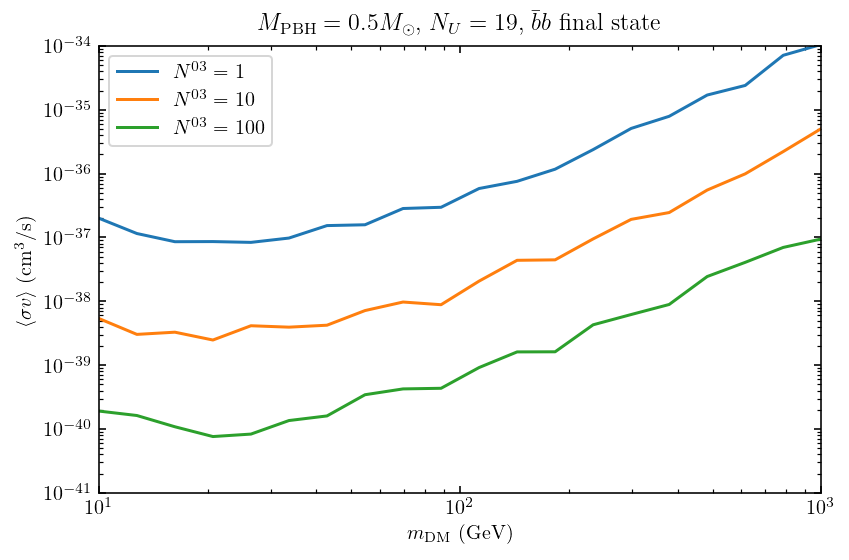

In [74]:
for n_gw_det in n_gw_dets:
    plt.plot(m_dms, sv_constraints[n_gw_det], label=r"$N^{03} = %i$" % n_gw_det)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title(r"$M_{\mathrm{PBH}} = %.1f M_\odot$, $N_U=%i$, $\bar{b} b$ final state" %
          (m_pbh, n_u))
plt.tick_params(axis='both', which='both', top=True, right=True, direction="in")
plt.xlim(m_dms[[0, -1]])
# plt.ylim(1e-41, 1e-23)
plt.axhline(3e-26, linestyle='--', color='k', alpha=0.5)
# plt.text(4e2, 2e-27, r"$\langle \sigma v \rangle_{\mathrm{thermal}}$")

# LIGO 03, 0.5M_sun
plt.ylim(1e-41, 1e-34)
# plt.text(2e1, 2e-37, r"$N^{ET} = 1$", color=colors[0])
# plt.text(2e1, 7e-39, r"$N^{ET} = 10$", color=colors[1])
# plt.text(4e2, 1e-39, r"$N^{ET} = 100$", color=colors[2])
# Einstein telescope
# plt.ylim(1e-36, 2e-31)
# plt.text(2e1, 4e-34, r"$N^{ET} = 1$", color=colors[0])
# plt.text(2e1, 4e-35, r"$N^{ET} = 10$", color=colors[1])
# plt.text(1e2, 3.5e-36, r"$N^{ET} = 100$", color=colors[2])

plt.legend()
plt.tight_layout()
# plt.savefig("figures/et_M=%.1f_limits_v1.pdf" % m_pbh)

In [ ]:
os.system("say 'Done!'")

In [21]:
for n_gw_det in n_gw_dets:
    np.savetxt("data/sv_lim_M=%.1f_n=%i_fs=b_cuts=1610.07587.csv" % (m_pbh, n_gw_det),
               sv_constraints[n_gw_det])

# Examine fluxes and number of detectable point sources

## Testing correctness of efficient sampling

In [4]:
n_det_pbhs = []
n_det_pbhs_err = []
m_pbhs = np.logspace(-1, 2, 20)  # M_sun
m_dm = 100  # GeV
sv = 3e-26  # cm^3/s
fluxes = []

for m_pbh in m_pbhs:
    s = PBHHaloSim(mass_dist=m_pbh, f_pbh=1e-8, m_dm=m_dm, sv=sv,
                   flux_type="dnde", fs="b", b_cut=20, flux_thresh=7e-10,
                   n_samples=100000)
    s.run(efficient_angular_sampling=True, truncate_radial_samples=True)
    n_det_pbhs.append(s.n_det)
    n_det_pbhs_err.append(s.n_det_err)
    fluxes.append(s.fluxes)

n_det_pbhs = np.array(n_det_pbhs)
n_det_pbhs_err = np.array(n_det_pbhs_err)
fluxes = np.array(fluxes)

In [5]:
s._radial_dist_cdf(8.33 + s.d_ms[0]) - s._radial_dist_cdf(0)

0.10952009235377821

In [8]:
3/alpha_mw, 2/alpha_mw/r_s_mw**alpha_mw * (8.33 + s.d_ms[0])**alpha_mw

(17.64705882352941, 12.698600920475494)

In [9]:
1/(2/alpha_mw/r_s_mw**alpha_mw)

0.1501713055291558

<ErrorbarContainer object of 3 artists>

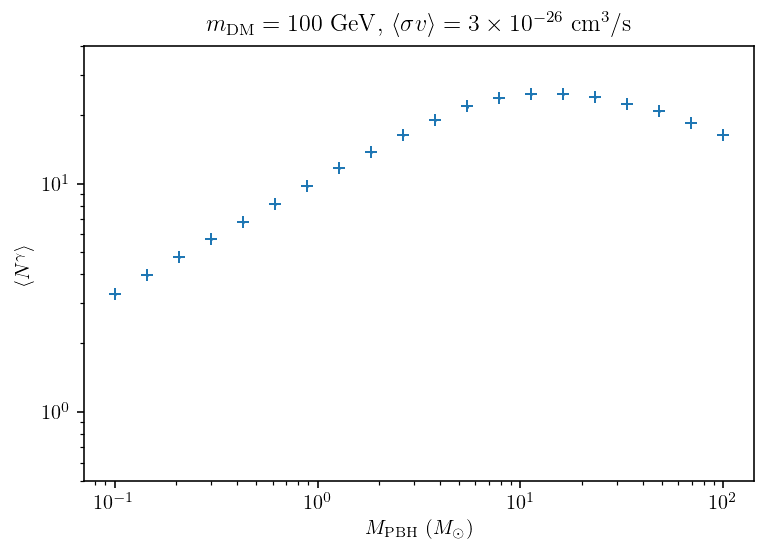

In [67]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$M_{\mathrm{PBH}}$ ($M_\odot$)")
plt.ylabel(r"$\langle N^\gamma \rangle$")
plt.title(r"$m_{\mathrm{DM}} = 100~\mathrm{GeV}$, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}~\mathrm{cm}^3/\mathrm{s}$")
plt.ylim(5e-1, 4e1)

plt.errorbar(m_pbhs, n_det_pbhs, yerr=n_det_pbhs_err, fmt="+")

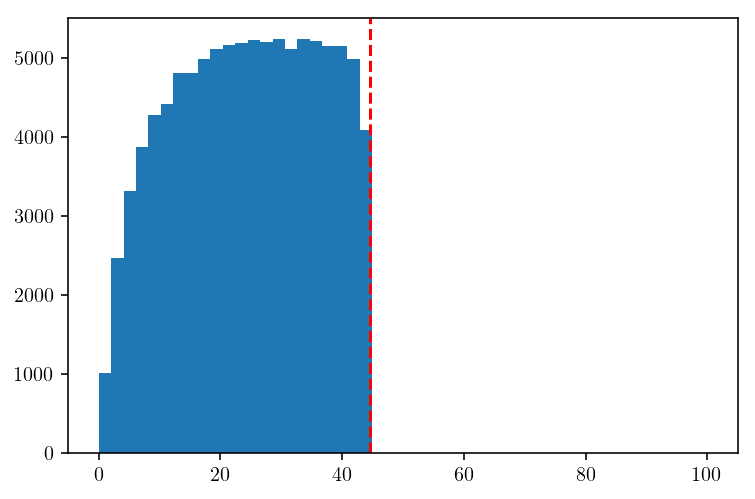

In [68]:
plt.hist(s.positions_abs[0], bins=np.linspace(0, 100))
plt.axvline(d_earth + s.d_ms[0], linestyle='--', color='r')

Text(0.5, 1.0, '$m_{\\mathrm{DM}} = 100~\\mathrm{GeV}$, $\\langle \\sigma v \\rangle = 3\\times 10^{-26}~\\mathrm{cm}^3/\\mathrm{s}$')

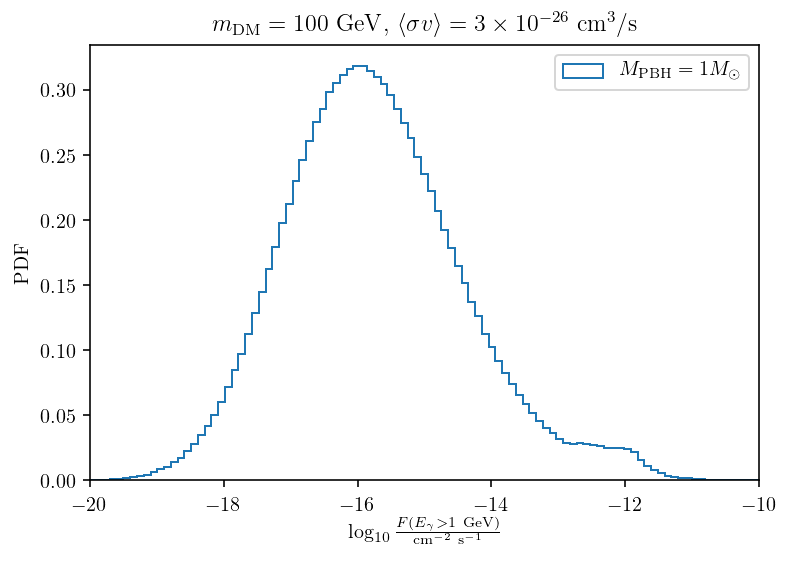

In [81]:
# NOTE: this plot is only correct when efficient_angular_sampling is False!
for m_pbh, f in zip(m_pbhs, fluxes):
    plt.hist(np.log10(f), bins=np.linspace(-20, -10, 100), density=True,
             histtype="step", label=r"$M_{\mathrm{PBH}} = %i M_\odot$" % m_pbh)
    
plt.xlim(-20, -10)
plt.legend()
plt.xlabel(r"$\log_{10} \frac{F(E_\gamma > 1~\mathrm{GeV})}{\mathrm{cm}^{-2}~\mathrm{s}^{-1}}$")
plt.ylabel("PDF")
plt.title(r"$m_{\mathrm{DM}} = 100~\mathrm{GeV}$, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}~\mathrm{cm}^3/\mathrm{s}$")

## Trying to fit flux distribution analytically

**Note:** this plot is only correct when `efficient_angular_sampling` is `False`!

Text(0.5, 1.0, '$m_{\\mathrm{DM}} = 100~\\mathrm{GeV}$, $\\langle \\sigma v \\rangle = 3\\times 10^{-26}~\\mathrm{cm}^3/\\mathrm{s}$')

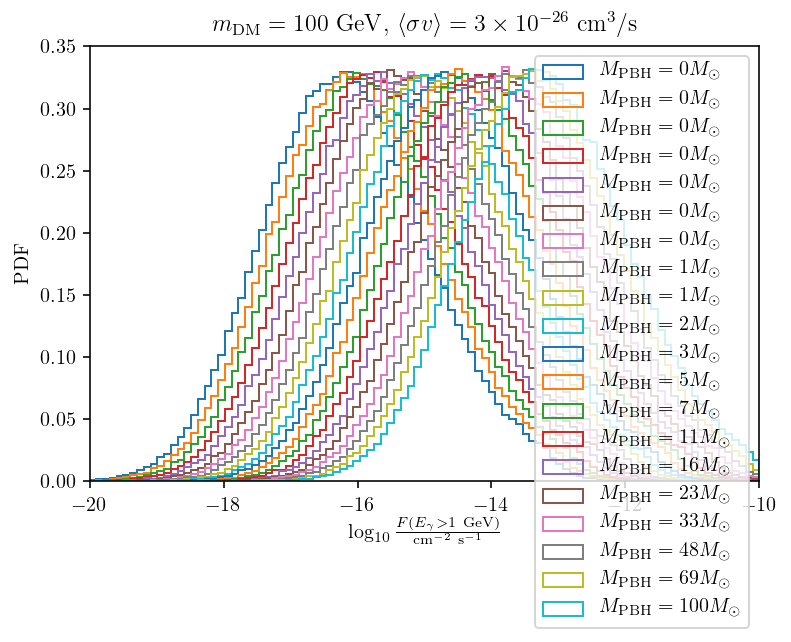

In [394]:
for m_pbh, f in zip(m_pbhs, fluxes):
    plt.hist(np.log10(f), bins=np.linspace(-20, -10, 100), density=True,
             histtype="step", label=r"$M_{\mathrm{PBH}} = %i M_\odot$" % m_pbh)
    
plt.xlim(-20, -10)
plt.legend()
plt.xlabel(r"$\log_{10} \frac{F(E_\gamma > 1~\mathrm{GeV})}{\mathrm{cm}^{-2}~\mathrm{s}^{-1}}$")
plt.ylabel("PDF")
plt.title(r"$m_{\mathrm{DM}} = 100~\mathrm{GeV}$, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}~\mathrm{cm}^3/\mathrm{s}$")

Studying scaling of flux distribution

In [492]:
rs = np.random.gamma(shape=3/alpha_mw,
                     scale=alpha_mw*r_s_mw**alpha_mw/2,
                     size=1000000)**(1/alpha_mw)

-2*np.mean(np.log(rs))

-11.129136986435627

In [491]:
-2*np.mean(np.log(rs))

-11.126712273197498

In [478]:
int_e_dnde_interps["b"](1000) / int_e_dnde_interps["b"](100)

11.634427901749843

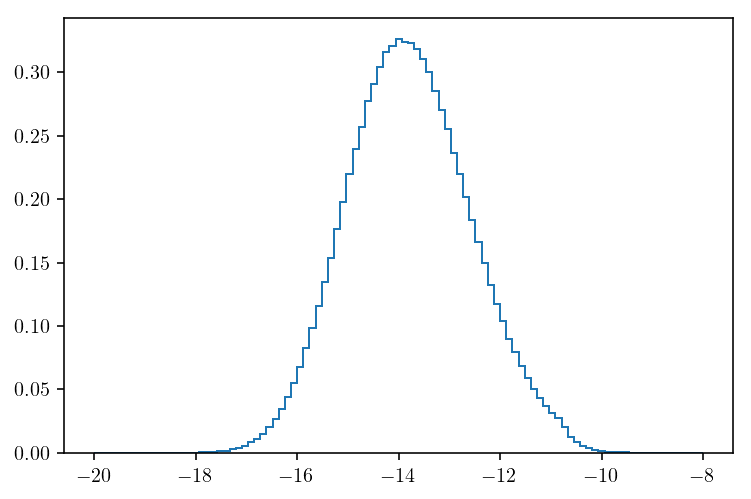

In [484]:
bins = np.linspace(-20, -8, 100)
plt.hist(np.log10(fluxes[0]), histtype="step", density=True, bins=bins);

# Scratch: numerical integration rather than MC

In [ ]:
flux_fact = int_e_dnde_interps["b"]

def integrand(r, th, ph, m_pbh=10., m_dm=100., sv=3e-26, fs="b"):
    flux_fact = int_e_dnde_interps[fs](m_dm)
    rho_max = self.m_dm / (self.sv * age_of_universe * yr_to_s)
    r_cut = 1.3e-7 * (100./self.m_dm * self.sv/3e-26)**(4/9) * (self.m_pbhs/1.)**(1/3)
    # Added missing factor of 1/2
    self.ann_rates = 4*np.pi*self.sv*rho_max**2 * (kpc_to_cm*r_cut)**3 / (2*self.m_dm**2)
    
    fluxes = ann_rate * flux_fact / (4*np.pi * (kpc_to_cm*dist)**2)